In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [5]:
inputfilename = 'newImage2.jpg'

In [6]:
contour_img_1 = cv2.imread(inputfilename)

In [7]:
contour_img_1.shape

(32808, 12858, 3)

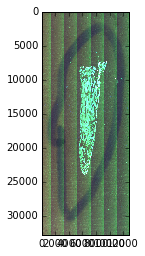

In [8]:
plt.imshow(contour_img_1)

In [9]:
contour_img_2 = cv2.cvtColor(contour_img_1, cv2.COLOR_BGR2GRAY)

In [10]:
contour_img_3 = cv2.GaussianBlur(contour_img_2,(5,5),0)

In [13]:
kernel = np.ones((5,5),np.uint8)

In [14]:
contour_img_4 = cv2.dilate(contour_img_3, kernel, iterations = 2)

In [16]:
thresh = 100

ret3,contour_img_5 = cv2.threshold(contour_img_4,thresh,255,cv2.THRESH_BINARY)

ERROR! Session/line number was not unique in database. History logging moved to new session 709


In [17]:
kernel = np.ones((5,5),np.uint8)

In [18]:
contour_img_6 = cv2.dilate(contour_img_5, kernel, iterations = 5) # decrease iteration

In [19]:
contour_img_7 = cv2.erode(contour_img_6,kernel,iterations = 2)

In [20]:
thresh = 240

ret3,contour_img_8 = cv2.threshold(contour_img_7,thresh,255,cv2.THRESH_BINARY)

# description of parameters http://www.pyimagesearch.com/2014/09/08/thresholding-simple-image-segmentation-using-opencv/

In [20]:
plt.imshow(contour_img_8, cmap = 'gray')

KeyboardInterrupt: 

In [21]:
lower = np.array([200])
upper = np.array([255])

In [22]:
shapeMask = cv2.inRange(contour_img_8, lower, upper)

In [23]:
(cnts, _) = cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [24]:
def max_contour(list_of_contours):
    
    '''
    function: find the contour with the biggest surface area from list of contours
    input: list of contours, as generated by cv2.findcontours
    output: index position
    '''
    
    max_contour = 0
    max_contour_index = 0

    for i in range(len(list_of_contours)):
        
        # calculate area for each contour object
        
        if cv2.contourArea(list_of_contours[i]) > max_contour:
            max_contour = cv2.contourArea(list_of_contours[i])
            max_contour_index = i

    return max_contour_index

In [25]:
biggest_contour = max_contour(cnts)

In [26]:
print "index position of biggest contour:", biggest_contour  
print "it has number of vertices:", len(cnts[biggest_contour])
print "estimated area is:", int(cv2.contourArea(cnts[biggest_contour]))

index position of biggest contour: 47
it has number of vertices: 2230
estimated area is: 2480252


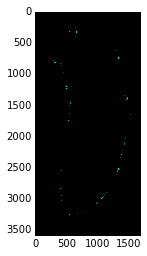

In [27]:
contour_img = np.zeros(contour_img_1.shape, np.uint8)
pts = np.array(cnts[biggest_contour], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(contour_img,[pts],True,(0,255,255))
plt.imshow(contour_img, cmap = 'gray')

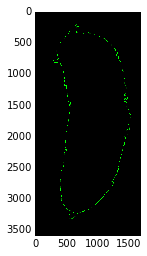

In [28]:
pts = np.array(cnts[biggest_contour], np.int32)
pts = pts.reshape((-1,1,2))
cv2.drawContours(contour_img, [pts], 0, (0,255,0), 3)
plt.imshow(contour_img)

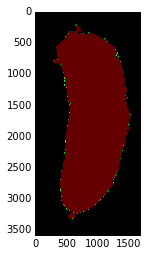

In [29]:
pts = np.array(cnts[biggest_contour], np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillConvexPoly(contour_img, pts, 100, lineType=8, shift=0)
plt.imshow(contour_img, cmap = 'gray')

### phase 2: object detection

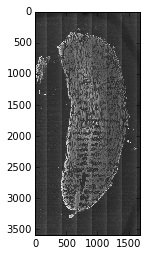

In [30]:
plt.imshow(contour_img_2, cmap = 'gray')

In [31]:
counting_img_1 = cv2.morphologyEx(contour_img_2, cv2.MORPH_TOPHAT, kernel)

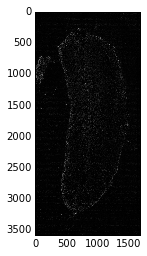

In [32]:
plt.imshow(counting_img_1, cmap = 'gray')

In [33]:
counting_img_2 = cv2.dilate(counting_img_1,kernel,iterations = 3)

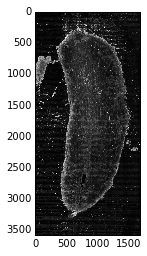

In [34]:
plt.imshow(counting_img_2, cmap = 'gray')

In [35]:
thresh_count = 100

In [36]:
ret3,counting_img_3 = cv2.threshold(counting_img_2,thresh_count,255,cv2.THRESH_BINARY)

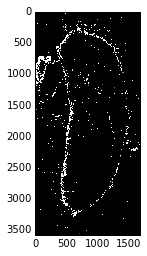

In [37]:
plt.imshow(counting_img_3, cmap = 'gray')

In [38]:
shapeMask_new = cv2.inRange(counting_img_3, lower, upper)

In [39]:
(cnts_nmj, _) = cv2.findContours(shapeMask_new.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print "%d objects detected" % (len(cnts_nmj))

468 objects detected


### Step 12: calculate centroids

In [40]:
def convert_to_centroid(coordinates):
    
    '''
    function: shrink each object to single pt, which can then be compared with nearest contour
    input: a single contour object
    output: tuple of centroid's coordinates
    '''
    
    total_x = 0
    total_y = 0

    for i in range(len(coordinates[0])):
        total_x += coordinates[i][0][0]
        total_y += coordinates[i][0][1]
        
        # find average x and y coordinates
        
        center_x = total_x / len(coordinates[0])
        center_y = total_y / len(coordinates[0])
        
    return (center_x, center_y) 

In [41]:
# convert list of contours into list of centroids

centroid_list = []

for i in range(len(cnts_nmj)):
    centroid_list.append(convert_to_centroid(cnts_nmj[i]))

In [42]:
len(centroid_list)

468

### Step 13: determine if each centroid is in tissue or not

In [43]:
def inside_tissue(centroid, image):

    '''
    function: if centroid is inside contour, then pixel intensity != 0
    input: (1) tuple of centroid coordinates and (2) image of original 
    output: boolean
    '''
    
    if (image[centroid[1], centroid[0]][0] != 0): 
        return True 
    else: 
        return False

### Step 14: create raw description file

In [44]:
def generate_description(cnts_nmj, centroid_list, biggest_contour, contour_img, thresh_count):
    
    '''
    function: generate csv file of total count
    inputs: 
    
    (1) list of total cmj count; 
    
    (2) list of centroids; 
    
    (3) position of biggest contour;
    
    (4) contour image; 
    
    (5) thresh_count - threshold value used to create binary image for counting
    
    output: dataframe object
    '''

    description = []

    # generate a csv of (1) coordinates, (2) area, (3) distance from boundary, (4) inside contour (bool)
    
    for i in range(len(cnts_nmj)):
        
        d_cd = centroid_list[i]
        d_area = cv2.contourArea(cnts_nmj[i])
        d_distance = cv2.pointPolygonTest(cnts[biggest_contour], centroid_list[i], True)
        d_inside = inside_tissue(centroid_list[i], contour_img)
        d_thresh_count = thresh_count
        
        description.append((d_cd, d_area, d_distance, d_inside, d_thresh_count))
        
    # convert into pandas dataframe for data analysis
        
    description_df = pd.DataFrame(description, columns = ['Coordinates', 'Area', 'Distance', 'inside', 'threshold'])
   
    return description_df

In [45]:
description_df = generate_description(cnts_nmj, centroid_list, biggest_contour, contour_img, thresh_count)

In [46]:
description_df.shape

(468, 5)

In [47]:
description_df['inside'].value_counts()

True     252
False    216
dtype: int64

### step 15: characterize

In [48]:
def review_analysis(imagefilename, csv_outputfilename, image_outputfilename, analysis_df, min_dist, min_area, radius):
    
    '''
    function: analyze image for objects

    input: (1) image file name; (2) name of output file; (3) name of modified image file;
    (4) raw description file; (5) minimum distance threshold; (6) minimum object size; (7) size of tags
    
    output: (1) subsetted csv file; (2) modified image file; (3) subsetted dataframe
    '''
    
    # following section subsets csv according to conditions
    
    analysis_df = analysis_df[analysis_df['Distance'] > min_dist]
    analysis_df = analysis_df[analysis_df['Area'] > min_area]
    analysis_df = analysis_df[analysis_df['inside'] == True]
    
    
    
    
    # modify image by highlighting objects 
    
    img_1 = cv2.imread(imagefilename)

    for i in analysis_df.index:
        cv2.circle(img_1, analysis_df['Coordinates'][i],radius,255,3)

    plt.imshow(img_1)

    
    
    # following section saves (1) subsetted csv and (2) modified image
    
    cv2.imwrite(image_outputfilename, img_1)
    analysis_df.to_csv(csv_outputfilename)
    return analysis_df
    

In [49]:
###### USER INPUTS ######

min_dist = 100
min_area = 250
radius = 25
csv_outputfilename = inputfilename + '_' + str(min_dist) + '_' + str(min_area) + 'final_count.csv'
image_outputfilename = inputfilename + '_' + str(min_dist) + '_' + str(min_area) + 'final_image.tif'

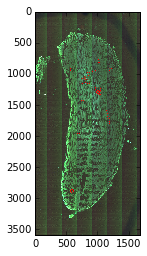

In [50]:
analysis_df = review_analysis(inputfilename, csv_outputfilename, image_outputfilename, description_df, min_dist, min_area, radius)

In [90]:
def crop_image1(index_position, analysis_df, delta, image):
    
    '''
    function: helper function to crop smaller tiles
    inputs: 
    
    (1) index position (int), as generated review analysis; 
    (2) list of contours (list), contains contour vertices
    (3) raw image (cv image)
    
    output: cropped image
    '''
    x = analysis_df.Coordinates[index_position][0]
    y = analysis_df.Coordinates[index_position][1]
    
    cropped_image = image[y - delta:y + delta, x - delta:x + delta]
    
    filename = "crop" + str(index_position) + ".tif"
    cv2.imwrite(filename, cropped_image)

In [91]:
crop_image1(201, analysis_df, 50, contour_img_1)

In [92]:
for i in analysis_df.index:
    crop_image1(i, analysis_df, 50, contour_img_1)